In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import ast

# reference: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/


import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pdpbox.pdp import pdp_isolate, pdp_plot


%matplotlib inline

In [2]:
bc = pd.read_csv("bankchurners.csv", low_memory=False)
print(bc.shape)

(10127, 22)


In [3]:
bc.info()
bc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Unnamed: 21
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,NaN
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,NaN
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,NaN
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,NaN
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,NaN


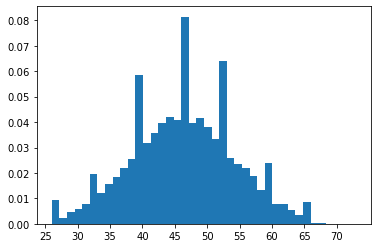

In [4]:
plt.hist(bc['Customer_Age'],bins=40,density=True)    # age follows normal curve
plt.xticks(range(25,75,5))
plt.show()

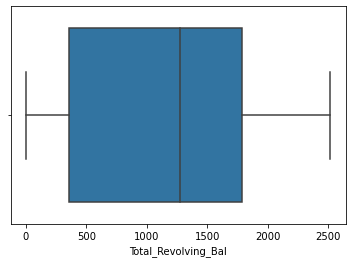

In [5]:
sns.boxplot(x=bc['Total_Revolving_Bal'])

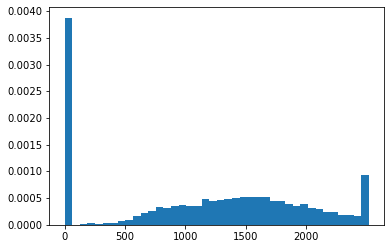

In [6]:
plt.hist(bc['Total_Revolving_Bal'],bins=40,density=True)    # Total revolving balance has a large amt of people with no real running balance follows normal curve
plt.xticks(range(0,2500,500))
plt.show()

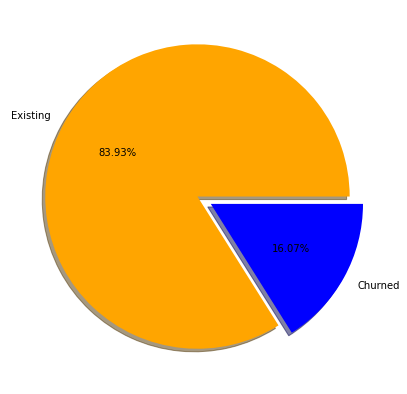

In [7]:
data_flag = bc.Attrition_Flag.value_counts(normalize=True)

colors = ("orange", "blue")

fig = plt.figure(figsize =(10, 7)) 
plt.pie(data_flag, labels = ['Existing', 'Churned'], autopct='%1.2f%%', shadow = True, explode=[0,0.1],colors = colors) 

plt.show()

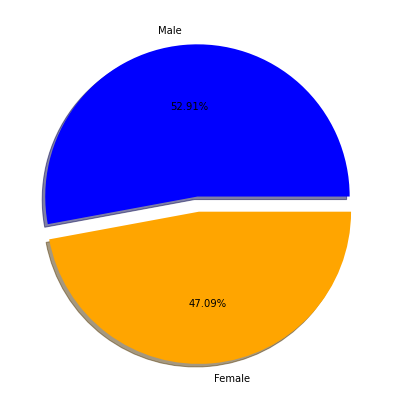

In [8]:
data_gender = bc.Gender.value_counts(normalize = True)

colors = ("blue", "orange")

fig = plt.figure(figsize =(10, 7)) 
plt.pie(data_gender, labels = ['Male', 'Female'], autopct='%1.2f%%', shadow = True, explode=[0,0.1],colors = colors) 

plt.show()

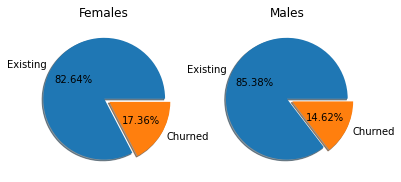

In [9]:
data_Female = bc.loc[bc['Gender']=='F']['Attrition_Flag'].value_counts()
data_Male = bc.loc[bc['Gender']=='M']['Attrition_Flag'].value_counts()

fig,(ax1,ax2) = plt.subplots(1,2)
ax1.pie(data_Female, labels = ['Existing', 'Churned'], explode=[0,0.1],shadow=True,autopct='%1.2f%%')
ax1.title.set_text('Females')
ax2.pie(data_Male,explode=[0,0.1],shadow=True,autopct='%1.2f%%',labels=['Existing','Churned'])
ax2.title.set_text('Males')
plt.show()


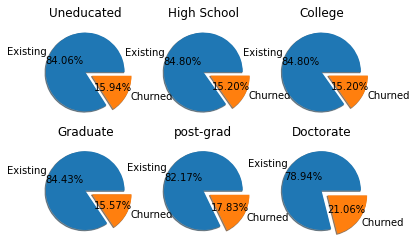

In [10]:

data_uneducated = bc.loc[bc['Education_Level']=='Uneducated']['Attrition_Flag'].value_counts()
data_high_school = bc.loc[bc['Education_Level']=='High School']['Attrition_Flag'].value_counts()
data_college = bc.loc[bc['Education_Level']=='College']['Attrition_Flag'].value_counts()
data_graduate = bc.loc[bc['Education_Level']=='Graduate']['Attrition_Flag'].value_counts()
data_post_grad = bc.loc[bc['Education_Level']=='Post-Graduate']['Attrition_Flag'].value_counts()
data_doctorate = bc.loc[bc['Education_Level']=='Doctorate']['Attrition_Flag'].value_counts()


fig,((axs2,axs3,axs4),(axs5,axs6,axs7)) = plt.subplots(2,3)

axs2.pie(data_uneducated,explode=[0,0.2],shadow=True,autopct='%1.2f%%',labels=['Existing','Churned'])
axs2.title.set_text('Uneducated')

axs3.pie(data_high_school,explode=[0,0.2],shadow=True,autopct='%1.2f%%',labels=['Existing','Churned'])
axs3.title.set_text('High School')

axs4.pie(data_college,explode=[0,0.2],shadow=True,autopct='%1.2f%%',labels=['Existing','Churned'])
axs4.title.set_text('College')

axs5.pie(data_graduate,explode=[0,0.2],shadow=True,autopct='%1.2f%%',labels=['Existing','Churned'])
axs5.title.set_text('Graduate')

axs6.pie(data_post_grad,explode=[0,0.2],shadow=True,autopct='%1.2f%%',labels=['Existing','Churned'])
axs6.title.set_text('post-grad')

axs7.pie(data_doctorate,explode=[0,0.2],shadow=True,autopct='%1.2f%%',labels=['Existing','Churned'])
axs7.title.set_text('Doctorate')

plt.show()




data_unknown = bc.loc[bc['Education_Level']=='Unknown']['Attrition_Flag'].value_counts()
ax1.pie(data_unknown,explode=[0,0.1],shadow=True,autopct='%1.2f%%',labels=['Existing','Churned'])
ax1.title.set_text('Unknown')

This section will now be the cleaning section of the code. We will go one variable at a time and turn them into integers.
The data that was given to me said to delete the last two rows so I will also do that.

In [11]:
bc['Gender'].value_counts()

F    5358
M    4769
Name: Gender, dtype: int64

In [12]:
#Cleaning up the gender variable
#Male is 1 and Female is 0

bc.loc[bc["Gender"] == "M", "Gender"] = 1 
bc.loc[bc["Gender"] == "F", "Gender"] = 0

bc['Gender'] = bc['Gender'].astype(int)
bc['Gender'].value_counts()

0    5358
1    4769
Name: Gender, dtype: int64

In [13]:
#Attrition Flag cleaning

bc['Attrition_Flag'].value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

In [14]:
#Existing customers are 0 and Attrited customers are 1

bc.loc[bc["Attrition_Flag"] == "Existing Customer", "Attrition_Flag"] = 0
bc.loc[bc["Attrition_Flag"] == "Attrited Customer", "Attrition_Flag"] = 1

bc['Attrition_Flag'] = bc['Attrition_Flag'].astype(int)
bc['Attrition_Flag'].value_counts()

0    8500
1    1627
Name: Attrition_Flag, dtype: int64

In [15]:
bc['Education_Level'].value_counts()

Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64

In [16]:
#Unknown = 0
#Uneducated = 1
#High School = 2
#College = 3
#Graduate = 4
#Post-Grad = 5
#Doctorate = 6

bc.loc[bc["Education_Level"] == "Unknown", "Education_Level"] = 0
bc.loc[bc["Education_Level"] == "Uneducated", "Education_Level"] = 1
bc.loc[bc["Education_Level"] == "High School", "Education_Level"] = 2
bc.loc[bc["Education_Level"] == "College", "Education_Level"] = 3
bc.loc[bc["Education_Level"] == "Graduate", "Education_Level"] = 4
bc.loc[bc["Education_Level"] == "Post-Graduate", "Education_Level"] = 5
bc.loc[bc["Education_Level"] == "Doctorate", "Education_Level"] = 6



bc['Education_Level'] = bc['Education_Level'].astype(int)
bc['Education_Level'].value_counts()

4    3128
2    2013
0    1519
1    1487
3    1013
5     516
6     451
Name: Education_Level, dtype: int64

In [17]:

bc['Marital_Status'].value_counts()

Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64

In [18]:
#Unknown = 0
#Single = 1
#Married = 2
#Divorced = 3

bc.loc[bc["Marital_Status"] == "Unknown", "Marital_Status"] = 0
bc.loc[bc["Marital_Status"] == "Single", "Marital_Status"] = 1
bc.loc[bc["Marital_Status"] == "Married", "Marital_Status"] = 2
bc.loc[bc["Marital_Status"] == "Divorced", "Marital_Status"] = 3

bc['Marital_Status'] = bc['Marital_Status'].astype(int)
bc['Marital_Status'].value_counts()

2    4687
1    3943
0     749
3     748
Name: Marital_Status, dtype: int64

In [19]:
bc['Income_Category'].value_counts()

Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64

In [20]:
bc.loc[bc["Income_Category"] == "Unknown", "Income_Category"] = 0
bc.loc[bc["Income_Category"] == "Less than $40K", "Income_Category"] = 1
bc.loc[bc["Income_Category"] == "$40K - $60K", "Income_Category"] = 2
bc.loc[bc["Income_Category"] == "$60K - $80K", "Income_Category"] = 3
bc.loc[bc["Income_Category"] == "$80K - $120K", "Income_Category"] = 4
bc.loc[bc["Income_Category"] == "$120K +", "Income_Category"] = 5

bc['Income_Category'] = bc['Income_Category'].astype(int)
bc['Income_Category'].value_counts()

1    3561
2    1790
4    1535
3    1402
0    1112
5     727
Name: Income_Category, dtype: int64

In [21]:
bc['Card_Category'].value_counts()

Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64

In [22]:
bc.loc[bc["Card_Category"] == "Blue", "Card_Category"] = 0
bc.loc[bc["Card_Category"] == "Silver", "Card_Category"] = 1
bc.loc[bc["Card_Category"] == "Gold", "Card_Category"] = 2
bc.loc[bc["Card_Category"] == "Platinum", "Card_Category"] = 3

bc['Card_Category'] = bc['Card_Category'].astype(int)
bc['Card_Category'].value_counts()

0    9436
1     555
2     116
3      20
Name: Card_Category, dtype: int64

Now for the Regression

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Unnamed: 21
CLIENTNUM,1.000000,-0.046430,0.007613,0.020188,0.006772,-0.006946,0.003284,0.026295,0.002086,0.134588,...,0.005694,0.005708,0.000825,0.005633,0.017369,-0.019692,-0.002961,0.007696,0.000266,NaN
Attrition_Flag,-0.046430,1.000000,0.018203,-0.037272,0.018991,0.008796,-0.018597,-0.013577,0.002354,0.013687,...,0.204491,-0.023873,-0.263053,-0.000285,-0.131063,-0.168598,-0.371403,-0.290054,-0.178410,NaN
Customer_Age,0.007613,0.018203,1.000000,-0.017312,-0.122254,-0.002369,0.011265,0.023508,-0.018235,0.788912,...,-0.018452,0.002476,0.014780,0.001151,-0.062042,-0.046446,-0.067097,-0.012143,0.007114,NaN
Gender,0.020188,-0.037272,-0.017312,1.000000,0.004563,-0.005087,0.000007,0.786608,0.080093,-0.006728,...,0.039987,0.420806,0.029658,0.418059,0.026712,0.024890,-0.067454,-0.005800,-0.257851,NaN
Dependent_count,0.006772,0.018991,-0.122254,0.004563,1.000000,0.000472,-0.000337,0.066278,0.030469,-0.103062,...,-0.040505,0.068065,-0.002688,0.068291,-0.035439,0.025046,0.049912,0.011087,-0.037135,NaN
Education_Level,-0.006946,0.008796,-0.002369,-0.005087,0.000472,1.000000,0.014875,-0.011677,0.014989,0.006613,...,-0.006280,-0.002354,-0.006800,-0.001743,-0.010040,-0.007460,-0.004307,-0.016692,-0.001849,NaN
Marital_Status,0.003284,-0.018597,0.011265,0.000007,-0.000337,0.014875,1.000000,0.006557,-0.043905,0.012084,...,-0.001476,-0.031292,0.025386,-0.033562,0.036210,-0.044553,-0.075888,-0.000258,0.027451,NaN
Income_Category,0.026295,-0.013577,0.023508,0.786608,0.066278,-0.011677,0.006557,1.000000,0.077326,0.022122,...,0.023113,0.475972,0.034718,0.472760,0.011352,0.019651,-0.054569,-0.012657,-0.246476,NaN
Card_Category,0.002086,0.002354,-0.018235,0.080093,0.030469,0.014989,-0.043905,0.077326,1.000000,-0.012535,...,-0.000442,0.492446,0.026304,0.489985,0.007385,0.196003,0.134275,-0.007261,-0.198711,NaN
Months_on_book,0.134588,0.013687,0.788912,-0.006728,-0.103062,0.006613,0.012084,0.022122,-0.012535,1.000000,...,-0.010774,0.007507,0.008623,0.006732,-0.048959,-0.038591,-0.049819,-0.014072,-0.007541,NaN


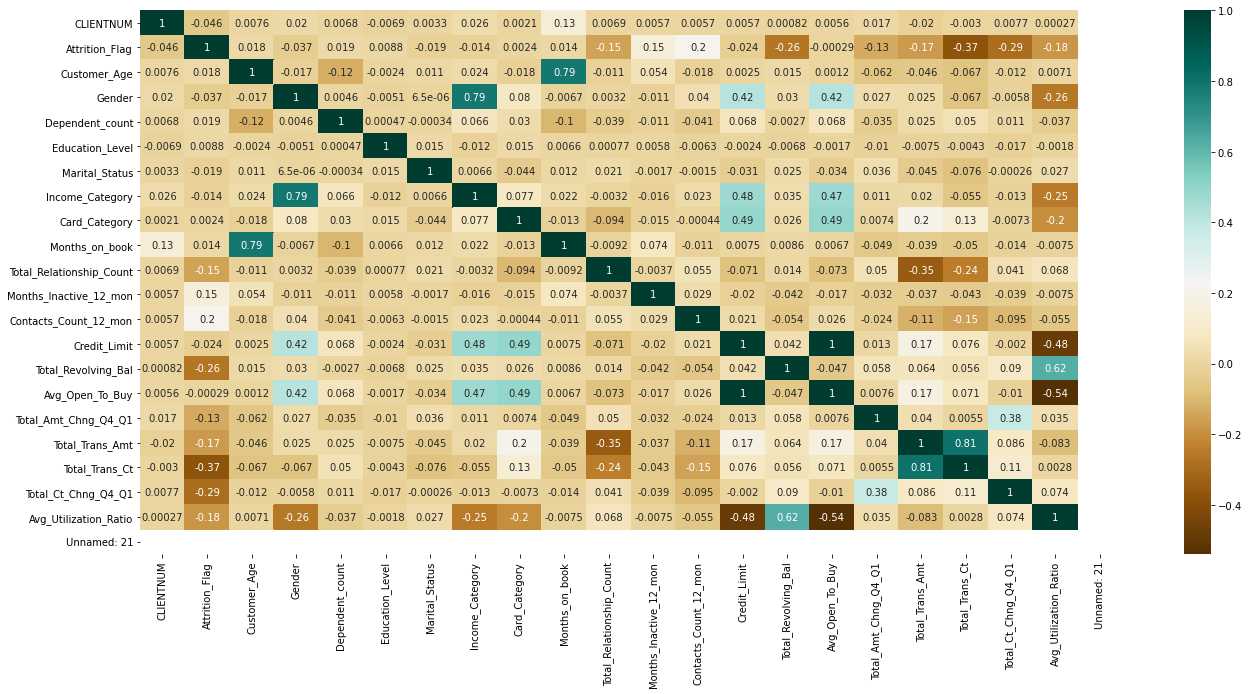

In [23]:
plt.figure(figsize=(22,10))
c = bc.corr()
sns.heatmap(c,cmap='BrBG',annot=True)
c

In [24]:
bc.info()
bc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  int32  
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  int32  
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  int32  
 6   Marital_Status            10127 non-null  int32  
 7   Income_Category           10127 non-null  int32  
 8   Card_Category             10127 non-null  int32  
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Unnamed: 21
0,768805383,0,45,1,3,2,2,3,0,39,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,NaN
1,818770008,0,49,0,5,4,1,1,0,44,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,NaN
2,713982108,0,51,1,3,4,2,4,0,36,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,NaN
3,769911858,0,40,0,4,2,0,1,0,34,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,NaN
4,709106358,0,40,1,3,1,2,3,0,21,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,NaN


In [25]:
x_columns = ['Customer_Age','Gender','Dependent_count','Education_Level','Marital_Status','Income_Category','Card_Category','Months_on_book','Total_Relationship_Count','Months_Inactive_12_mon','Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal','Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']

In [26]:
#Split the data
X = bc[x_columns]
y = bc['Attrition_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)

In [27]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

clftree = DecisionTreeClassifier(max_depth=3, random_state=24)
clftree.fit(X, y)

DecisionTreeClassifier(max_depth=3, random_state=24)

In [28]:
from sklearn.tree.export import export_text

r = export_text(clftree, feature_names = x_columns)
print(r)

|--- Total_Trans_Ct <= 54.50
|   |--- Total_Revolving_Bal <= 613.50
|   |   |--- Total_Ct_Chng_Q4_Q1 <= 0.65
|   |   |   |--- class: 1
|   |   |--- Total_Ct_Chng_Q4_Q1 >  0.65
|   |   |   |--- class: 0
|   |--- Total_Revolving_Bal >  613.50
|   |   |--- Total_Relationship_Count <= 2.50
|   |   |   |--- class: 1
|   |   |--- Total_Relationship_Count >  2.50
|   |   |   |--- class: 0
|--- Total_Trans_Ct >  54.50
|   |--- Total_Trans_Amt <= 5365.00
|   |   |--- Total_Trans_Ct <= 57.50
|   |   |   |--- class: 0
|   |   |--- Total_Trans_Ct >  57.50
|   |   |   |--- class: 0
|   |--- Total_Trans_Amt >  5365.00
|   |   |--- Total_Trans_Ct <= 78.50
|   |   |   |--- class: 1
|   |   |--- Total_Trans_Ct >  78.50
|   |   |   |--- class: 0



In [29]:
# pip install pydotplus

# pip install graphviz
# conda install graphviz
# add the location of 'gvedit.exe' file to the user's environment variable

import pydotplus as pdp
from IPython.display import Image
from io import StringIO


# This function creates images of tree models using pydotplus
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=x_columns, class_names=classn, filled=filled)
    graph = pdp.graph_from_dot_data(dot_data.getvalue())
    return(graph)

In [30]:
#Best model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_features=10, random_state=1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Sensitivity = %s" %(tp/(tp+fn)))
print("Specificity = %s" %(tn/(tn+fp)))
print("Accuracy = %s" %((tn+tp)/(tn+tp+fn+fp)))
print(classification_report(y_test, y_pred)) 
auc_score = roc_auc_score(y_test, y_pred)
print('AUC: %.5f' % auc_score)

Sensitivity = 0.8726114649681529
Specificity = 0.9879283489096573
Accuracy = 0.9700559394537677
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2568
           1       0.93      0.87      0.90       471

    accuracy                           0.97      3039
   macro avg       0.95      0.93      0.94      3039
weighted avg       0.97      0.97      0.97      3039

AUC: 0.93027


In [31]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier() 
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)


confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Sensitivity = %s" %(tp/(tp+fn)))
print("Specificity = %s" %(tn/(tn+fp)))
print("Accuracy = %s" %((tn+tp)/(tn+tp+fn+fp)))
print(classification_report(y_test, y_pred)) 
auc_score = roc_auc_score(y_test, y_pred)
print('AUC: %.5f' % auc_score)

Sensitivity = 0.8683651804670913
Specificity = 0.9809190031152648
Accuracy = 0.9634748272458046
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2568
           1       0.89      0.87      0.88       471

    accuracy                           0.96      3039
   macro avg       0.93      0.92      0.93      3039
weighted avg       0.96      0.96      0.96      3039

AUC: 0.92464


In [32]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier() 
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Sensitivity = %s" %(tp/(tp+fn)))
print("Specificity = %s" %(tn/(tn+fp)))
print("Accuracy = %s" %((tn+tp)/(tn+tp+fn+fp)))
print(classification_report(y_test, y_pred)) 
auc_score = roc_auc_score(y_test, y_pred)
print('AUC: %.5f' % auc_score)

Sensitivity = 0.8577494692144374
Specificity = 0.9890965732087228
Accuracy = 0.9687397170121751
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2568
           1       0.94      0.86      0.89       471

    accuracy                           0.97      3039
   macro avg       0.95      0.92      0.94      3039
weighted avg       0.97      0.97      0.97      3039

AUC: 0.92342


In [33]:
from sklearn.linear_model import LogisticRegression
# build the logit regression model, using the training dataset
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# generate predicted label for the test dataset 
y_pred = logreg.predict(X_test)
# generate predicted probability  
pred_probs = logreg.predict_proba(bc[x_columns])
# create a new column to store the probability
y_pred = pred_probs[:,1]

In [34]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Sensitivity = %s" %(tp/(tp+fn)))
print("Specificity = %s" %(tn/(tn+fp)))
print("Accuracy = %s" %((tn+tp)/(tn+tp+fn+fp)))
print(classification_report(y_test, y_pred)) 
auc_score = roc_auc_score(y_test, y_pred)
print('AUC: %.5f' % auc_score)

Sensitivity = 0.5732484076433121
Specificity = 0.9509345794392523
Accuracy = 0.8923988153998026
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2568
           1       0.68      0.57      0.62       471

    accuracy                           0.89      3039
   macro avg       0.80      0.76      0.78      3039
weighted avg       0.89      0.89      0.89      3039

AUC: 0.76209


In [35]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit( X_train, y_train )
y_pred = nb.predict(X_test)

confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Sensitivity = %s" %(tp/(tp+fn)))
print("Specificity = %s" %(tn/(tn+fp)))
print("Accuracy = %s" %((tn+tp)/(tn+tp+fn+fp)))
print(classification_report(y_test, y_pred)) 
auc_score = roc_auc_score(y_test, y_pred)
print('AUC: %.5f' % auc_score)

Sensitivity = 0.6348195329087049
Specificity = 0.9376947040498442
Accuracy = 0.8907535373478118
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      2568
           1       0.65      0.63      0.64       471

    accuracy                           0.89      3039
   macro avg       0.79      0.79      0.79      3039
weighted avg       0.89      0.89      0.89      3039

AUC: 0.78626


from sklearn.naive_bayes import MultinomialNB
multi = MultinomialNB().fit(X_train, y_train)
y_pred['Multinomial'] = multi.predict(X_test)
y_pred = multi.predict(X_test)

confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Sensitivity = %s" %(tp/(tp+fn)))
print("Specificity = %s" %(tn/(tn+fp)))
print("Accuracy = %s" %((tn+tp)/(tn+tp+fn+fp)))
print(classification_report(y_test, y_pred)) 
auc_score = roc_auc_score(y_test, y_pred)
priprint('AUC: %.5f' % auc_score)nt(auc_score)

from sklearn.svm import SVC, LinearSVC
svc = SVC(C= 1.0, kernel='linear')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Sensitivity = %s" %(tp/(tp+fn)))
print("Specificity = %s" %(tn/(tn+fp)))
print("Accuracy = %s" %((tn+tp)/(tn+tp+fn+fp)))
print(classification_report(y_test, y_pred)) 
auc_score = roc_auc_score(y_test, y_pred)
print(auc_score)

In [36]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))
mlp.fit(X_train,y_train)
y_pred = mlp.predict(X_test)

confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Sensitivity = %s" %(tp/(tp+fn)))
print("Specificity = %s" %(tn/(tn+fp)))
print("Accuracy = %s" %((tn+tp)/(tn+tp+fn+fp)))
print(classification_report(y_test, y_pred)) 
auc_score = roc_auc_score(y_test, y_pred)
print('AUC: %.5f' % auc_score)

Sensitivity = 0.28450106157112526
Specificity = 0.9127725856697819
Accuracy = 0.8153998025666338
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2568
           1       0.37      0.28      0.32       471

    accuracy                           0.82      3039
   macro avg       0.62      0.60      0.61      3039
weighted avg       0.80      0.82      0.80      3039

AUC: 0.59864
